# Summary

In this notebook, an exploratory data analysis (EDA) will be conducted to understand the dataset and the relationships between its features before starting to implement a mathematical model to predict the target variable.
At the end of the notebook, I experimented with various models and ultimately chose the gradient boosting architecture

# Detail


This notebook was worked on using the information related to this [Kaggle competition: House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview).  
The goal of this notebook is to achieve a better understanding of the data and to carry out the end-to-end process for the development of a machine learning model.

For the development, the decision was made to prioritize the delivery of a finished model as soon as possible. The main focus was not to obtain the best possible metrics but to maintain the quality of the development.  
This is why there are some data transformations or analyses that could be further studied to increase the performance achieved.

The analysis was divided into the following sections:

- Univariate Analysis
- Bivariate Analysis
- Model selection

## Setting up environment

### Installing Dependencies

### **After executing this cell, it will be necessary to restart the runtime environment**

### Importing libraries

In [45]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split

from ydata_profiling import ProfileReport

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from sklearn.base import RegressorMixin

In [46]:
pd.options.plotting.backend = "plotly"

## Function definition

In [47]:
def calculate_outlier_percentage(data, threshold = 1.5):

    outlier_percentages = []

    for column in data.columns:
        # Extract the column data as a NumPy array
        column_data = data[column].values

        # Calculate the IQR and the lower and upper bounds for potential outliers
        Q1 = np.percentile(column_data, 25)
        Q3 = np.percentile(column_data, 75)
        IQR = Q3 - Q1

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Identify the outliers
        num_outliers = len([x for x in column_data if x <
                           lower_bound or x > upper_bound])

        # Calculate the percentage of outliers
        percentage = (num_outliers / len(column_data)) * 100

        outlier_percentages.append((column, percentage))

    # Create a new DataFrame with the outlier percentages
    result_df = pd.DataFrame(outlier_percentages,
                             columns=['Column', 'Outlier Percentage [%]'])

    # Sort the DataFrame in descending order by "Outlier Percentage"
    result_df = result_df.sort_values(by='Outlier Percentage [%]',
                                      ascending=False)

    return result_df

def calculate_null_percentage(data):

    # Calculate the percentage of null values for each column
    null_percentages = (data.isnull().mean() * 100).round(2)

    # Create a DataFrame to store the results
    result_df = pd.DataFrame({'Column': null_percentages.index,
                              'Null Percentage [%]': null_percentages.values})

    # Sort the DataFrame in descending order by "Null Percentage"
    result_df = result_df.sort_values(
        by='Null Percentage [%]', ascending=False)

    return result_df


def outlier_diagnostic_plots(df, variable):
   
    fig, axes = plt.subplots(1, 3, figsize=(20, 4))

    # Histogram
    sns.histplot(df[variable], bins=30, kde=True, ax=axes[0])
    axes[0].set_title('Histogram')

    # QQ plot
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    axes[1].set_title('QQ Plot')

    # Box plot
    sns.boxplot(y=df[variable], ax=axes[2])
    axes[2].set_title('Box & Whiskers')

    fig.suptitle(variable, fontsize=16)
    plt.show()


def feature_target_correlation_df(df, target_column):

    if target_column not in df.columns:
        raise ValueError("Target column not found in the DataFrame.")

    feature_columns = [col for col in df.columns if col != target_column]
    correlations = df[feature_columns].corrwith(df[target_column])
    correlation_df = pd.DataFrame({'Correlation': correlations})
    correlation_df['Absolute Correlation'] = correlation_df['Correlation'].abs()

    # Sort the DataFrame in descending order of absolute correlations
    correlation_df = correlation_df.sort_values(
        by='Absolute Correlation', ascending=False)
    correlation_df.drop(columns=['Absolute Correlation'], inplace=True)

    return correlation_df


def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y, palette="husl")
    plt.xticks(rotation=90)


def load_and_split_data(data_frame, target_col):
    
    # Split the dataset into features (X) and the target variable (y)
    X = data_frame.drop(target_col, axis=1)
    y = data_frame[target_col]

    # Split the data into a training and validation set
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_val, y_train, y_val


def train_regressor(model, X_train, y_train, param_grid):

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    return best_model

from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np


class CappingTransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer for capping (winsorizing) numerical data using the Interquartile Range (IQR) and a threshold.

    Parameters:
    -----------
    threshold : float, optional (default=1.5)
        The threshold multiplier for the IQR. Determines how far beyond the IQR the limits should extend.

    Attributes:
    -----------
    lower_limit : float
        The lower limit for capping, calculated during fitting.
    upper_limit : float
        The upper limit for capping, calculated during fitting.

    Methods:
    --------
    fit(X, y=None):
        Calculate the lower and upper limits based on the data distribution during training.

    transform(X, y=None):
        Apply capping to the input data using the precomputed lower and upper limits.

    Example Usage:
    -------------
    # Create a capping transformer with a threshold of 1.5
    capper = CappingTransformer(threshold=1.5)

    # Fit the transformer on data
    capper.fit(data)

    # Transform the data using the calculated limits
    capped_data = capper.transform(data)
    """

    def __init__(self, threshold=1.5):
        self.threshold = threshold
        self.lower_limit = None
        self.upper_limit = None

    def fit(self, X, y=None):
        """
        Fit the capping transformer to the input data and calculate lower and upper limits.

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            The input data for fitting the transformer.
        y : array-like, optional (default=None)
            Ignored. There is no need for a target variable.

        Returns:
        --------
        self : object
            Returns self for method chaining.
        """
        Q1 = np.percentile(X, 25)
        Q3 = np.percentile(X, 75)
        IQR = Q3 - Q1
        self.lower_limit = Q1 - self.threshold * IQR
        self.upper_limit = Q3 + self.threshold * IQR
        return self

    def transform(self, X, y=None):
        """
        Apply capping to the input data using the precomputed lower and upper limits.

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            The input data to be capped.

        y : array-like, optional (default=None)
            Ignored. There is no need for a target variable.

        Returns:
        --------
        capped_X : ndarray, shape (n_samples, n_features)
            The capped input data.
        """
        capped_X = np.copy(X)
        capped_X[capped_X < self.lower_limit] = self.lower_limit
        capped_X[capped_X > self.upper_limit] = self.upper_limit
        return capped_X

    def get_feature_names_out(self, input_features=None):
        """
        Get feature names for transformed data. In this case, the names are preserved.

        Parameters:
        -----------
        input_features : array-like, shape (n_features,), optional (default=None)
            Names of the input features.

        Returns:
        --------
        output_feature_names : array, shape (n_features,)
            The feature names, which are the same as the input feature names.
        """
        return input_features

## Import Data

In this section, I read the training data and the file that contains the data descriptions.

The EDA was performed using the training data. Once the analysis was completed and the transformations were defined, a pipeline will be constructed and trained on the training data, which will then transform both the training and test datasets. This decision was made to prevent data leakage

In [48]:
train_df = pd.read_csv('../data/train.csv')
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42) # Saving a part of the dataset as test

train_df.to_csv('../data/train_pipeline.csv', index=False)
test_df.to_csv('../data/test_pipeline.csv', index=False)

In [49]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
254,255,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1957,1957,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,Gd,CBlock,TA,TA,No,Rec,922,Unf,0,392,1314,GasA,TA,Y,SBrkr,1314,0,0,1314,1,0,1,0,3,1,TA,5,Typ,0,NaN,Attchd,1957.0,RFn,1,294,TA,TA,Y,250,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,145000
1066,1067,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,7,1993,1994,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,799,799,GasA,Gd,Y,SBrkr,799,772,0,1571,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,RFn,2,380,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,178000
638,639,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,1Fam,1Story,5,7,1910,1950,Gable,CompShg,MetalSd,Wd Sdng,NaN,0.0,TA,TA,CBlock,Fa,TA,No,Unf,0,Unf,0,796,796,GasA,Gd,Y,FuseA,796,0,0,796,0,0,1,0,2,1,TA,4,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,P,328,0,164,0,0,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal,85000
799,800,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Feedr,Norm,1Fam,1.5Fin,5,7,1937,1950,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,252.0,TA,TA,BrkTil,Gd,TA,No,ALQ,569,Unf,0,162,731,GasA,Ex,Y,SBrkr,981,787,0,1768,1,0,1,1,3,1,Gd,7,Typ,2,TA,Detchd,1939.0,Unf,1,240,TA,TA,Y,0,0,264,0,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,175000
380,381,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,5,6,1924,1950,Gable,CompShg,BrkFace,Wd Sdng,NaN,0.0,TA,TA,BrkTil,TA,TA,No,LwQ,218,Unf,0,808,1026,GasA,TA,Y,SBrkr,1026,665,0,1691,0,0,2,0,3,1,Gd,6,Typ,1,Gd,Detchd,1924.0,Unf,1,308,TA,TA,Y,0,0,242,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,127000


In [50]:
with open('../data/data_description.txt', 'r') as file:
    data_description = file.read()

print(data_description)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

## Data Analysis

First, I obtain a quick overview of the dataframe and its information, including data types, the number of features, the count of non-null data, minimum and maximum values, among others.  

In this step, we can quickly observe that variables such as `Alley`, `FireplaceQu`, `PoolQC`, `Fence`, and `miscFeature` have a significant number of missing data. Due to the high amount of missing data in these variables, they will not be taken into consideration.

In a subsequent analysis, these variables with a significant amount of missing data could be further evaluated, and their missing data could be imputed using an imputation technique.

In [51]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1168.000000,1168.000000,951.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1162.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1104.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,730.904966,56.849315,70.343849,10689.642123,6.121575,5.584760,1970.965753,1984.897260,103.771945,446.023973,45.152397,570.595034,1061.771404,1169.354452,352.351027,5.696062,1527.401541,0.425514,0.057363,1.577055,0.381849,2.890411,1.047945,6.561644,0.618151,1978.662138,1.781678,476.273973,95.946918,49.578767,21.839041,3.812500,15.407534,2.955479,51.267123,6.356164,2007.818493,181441.541952
std,425.369088,42.531862,24.897021,10759.366198,1.367619,1.116062,30.675495,20.733955,173.032238,459.070977,158.217499,446.364551,440.676330,386.675268,439.570872,47.887106,524.432686,0.519969,0.236289,0.546912,0.499953,0.804855,0.225448,1.619706,0.645129,24.728938,0.740161,211.095373,129.685939,69.433580,62.083227,31.519664,55.881148,41.648504,553.039684,2.670707,1.322639,77263.583862
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,360.750000,20.000000,59.000000,7587.250000,5.000000,5.000000,1953.000000,1966.000000,0.000000,0.000000,0.000000,222.500000,796.000000,888.000000,0.000000,0.000000,1145.750000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.750000,1.000000,341.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,732.500000,50.000000,70.000000,9600.000000,6.000000,5.000000,1972.000000,1994.000000,0.000000,384.500000,0.000000,480.000000,997.500000,1095.000000,0.000000,0.000000,1473.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,482.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,165000.000000
75%,1101.750000,70.000000,80.000000,11700.000000,7.000000,6.000000,2001.000000,2004.000000,166.000000,721.000000,0.000000,810.250000,1299.250000,1396.750000,728.000000,0.000000,1792.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214925.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,5644.000000,1127.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,745000.000000


In [52]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 254 to 1126
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    951 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          74 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  OverallCond

In [53]:
# Defining numeric and categorical features of the dataset
numeric_features = train_df.select_dtypes(include = ['int64', 'float64']).columns
categorical_features = train_df.select_dtypes(include = ['object']).columns
target = ['SalePrice']

In [54]:
train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
254,255,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1957,1957,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,Gd,CBlock,TA,TA,No,Rec,922,Unf,0,392,1314,GasA,TA,Y,SBrkr,1314,0,0,1314,1,0,1,0,3,1,TA,5,Typ,0,NaN,Attchd,1957.0,RFn,1,294,TA,TA,Y,250,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,145000
1066,1067,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,7,1993,1994,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,799,799,GasA,Gd,Y,SBrkr,799,772,0,1571,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,RFn,2,380,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,178000
638,639,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,1Fam,1Story,5,7,1910,1950,Gable,CompShg,MetalSd,Wd Sdng,NaN,0.0,TA,TA,CBlock,Fa,TA,No,Unf,0,Unf,0,796,796,GasA,Gd,Y,FuseA,796,0,0,796,0,0,1,0,2,1,TA,4,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,P,328,0,164,0,0,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal,85000
799,800,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Feedr,Norm,1Fam,1.5Fin,5,7,1937,1950,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,252.0,TA,TA,BrkTil,Gd,TA,No,ALQ,569,Unf,0,162,731,GasA,Ex,Y,SBrkr,981,787,0,1768,1,0,1,1,3,1,Gd,7,Typ,2,TA,Detchd,1939.0,Unf,1,240,TA,TA,Y,0,0,264,0,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,175000
380,381,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,5,6,1924,1950,Gable,CompShg,BrkFace,Wd Sdng,NaN,0.0,TA,TA,BrkTil,TA,TA,No,LwQ,218,Unf,0,808,1026,GasA,TA,Y,SBrkr,1026,665,0,1691,0,0,2,0,3,1,Gd,6,Typ,1,Gd,Detchd,1924.0,Unf,1,308,TA,TA,Y,0,0,242,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,127000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,1096,20,RL,78.0,9317,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,6,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,24,Unf,0,1290,1314,GasA,Gd,Y,SBrkr,1314,0,0,1314,0,0,2,0,3,1,Gd,6,Typ,1,Gd,Attchd,2006.0,RFn,2,440,TA,TA,Y,0,22,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal,176432
1130,1131,50,RL,65.0,7804,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,4,3,1928,1950,Gable,CompShg,WdShing,Plywood,NaN,0.0,TA,TA,BrkTil,TA,TA,No,BLQ,622,Unf,0,500,1122,GasA,TA,Y,SBrkr,1328,653,0,1981,1,0,2,0,4,1,Gd,7,Min2,2,TA,Detchd,1981.0,Unf,2,576,TA,TA,Y,431,44,0,0,0,0,NaN,MnPrv,NaN,0,12,2009,WD,Normal,135000
1294,1295,20,RL,60.0,8172,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1955,1990,Hip,CompShg,WdShing,Plywood,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,167,Unf,0,697,864,GasA,TA,Y,SBrkr,864,0,0,864,1,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1957.0,Unf,2,572,TA,TA,N,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Normal,115000
860,861,50,RL,55.0,7642,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,1.5Fin,7,8,1918,1998,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,Gd,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,912,912,GasA,Gd,Y,SBrkr,912,514

## Variables

The dataset contains the following variables

1. `MiscFeature`: Miscellaneous feature not covered in other categories.
2. `MSZoning`: Identifies the general zoning classification of the sale.
3. `MSSubClass`: Identifies the type of dwelling involved in the sale.
4. `MSZoning`: Identifies the general zoning classification of the sale.
5. `LotFrontage`: Linear feet of street connected to the property.
6. `LotArea`: Lot size in square feet.
7. `Street`: Type of road access to the property.
8. `Alley`: Type of alley access to the property.
9. `LotShape`: General shape of the property.
10. `LandContour`: Flatness of the property.
11. `Utilities`: Type of utilities available.
12. `LotConfig`: Lot configuration.
13. `LandSlope`: Slope of the property.
14. `Neighborhood`: Physical locations within Ames city limits.
15. `Condition1`: Proximity to various conditions.
16. `Condition2`: Proximity to various conditions (if more than one is present).
17. `BldgType`: Type of dwelling.
18. `HouseStyle`: Style of dwelling.
19. `OverallQual`: Rates the overall material and finish of the house.
20. `OverallCond`: Rates the overall condition of the house.
21. `YearBuilt`: Original construction date.
22. `YearRemodAdd`: Remodel date (same as construction date if no remodeling or additions).
23. `RoofStyle`: Type of roof.
24. `RoofMatl`: Roof material.
25. `Exterior1st`: Exterior covering on the house.
26. `Exterior2nd`: Exterior covering on the house (if more than one material).
27. `MasVnrType`: Masonry veneer type.
28. `MasVnrArea`: Masonry veneer area in square feet.
29. `ExterQual`: Evaluates the quality of the material on the exterior.
30. `ExterCond`: Evaluates the present condition of the material on the exterior.
31. `Foundation`: Type of foundation.
32. `BsmtQual`: Evaluates the height of the basement.
33. `BsmtCond`: Evaluates the general condition of the basement.
34. `BsmtExposure`: Refers to walkout or garden level walls.
35. `BsmtFinType1`: Rating of basement finished area.
36. `BsmtFinSF1`: Type 1 finished square feet.
37. `BsmtFinType2`: Rating of basement finished area (if multiple types).
38. `BsmtFinSF2`: Type 2 finished square feet.
39. `BsmtUnfSF`: Unfinished square feet of basement area.
40. `TotalBsmtSF`: Total square feet of basement area.
41. `Heating`: Type of heating.
42. `HeatingQC`: Heating quality and condition.
43. `CentralAir`: Central air conditioning.
44. `Electrical`: Electrical system.
45. `1stFlrSF`: First Floor square feet.
46. `2ndFlrSF`: Second floor square feet.
47. `LowQualFinSF`: Low quality finished square feet (all floors).
48. `GrLivArea`: Above grade (ground) living area square feet.
49. `BsmtFullBath`: Basement full bathrooms.
50. `BsmtHalfBath`: Basement half bathrooms.
51. `FullBath`: Full bathrooms above grade.
52. `HalfBath`: Half baths above grade.
53. `Bedroom`: Bedrooms above grade (does NOT include basement bedrooms). DOESNT EXIST IN REAL DATA
54. `Kitchen`: Kitchens above grade. DOESNT EXIST IN REAL DATA
55. `KitchenQual`: Kitchen quality.
56. `TotRmsAbvGrd`: Total rooms above grade (does not include bathrooms).
57. `Functional`: Home functionality (Assume typical unless deductions are warranted).
58. `Fireplaces`: Number of fireplaces.
59. `FireplaceQu`: Fireplace quality.
60. `GarageType`: Garage location.
61. `GarageYrBlt`: Year garage was built.
62. `GarageFinish`: Interior finish of the garage.
63. `GarageCars`: Size of garage in car capacity.
64. `GarageArea`: Size of garage in square feet.
65. `GarageQual`: Garage quality.
66. `GarageCond`: Garage condition.
67. `PavedDrive`: Paved driveway.
68. `WoodDeckSF`: Wood deck area in square feet.
69. `OpenPorchSF`: Open porch area in square feet.
70. `EnclosedPorch`: Enclosed porch area in square feet.
71. `3SsnPorch`: Three season porch area in square feet.
72. `ScreenPorch`: Screen porch area in square feet.
73. `PoolArea`: Pool area in square feet.
74. `PoolQC`: Pool quality.
75. `Fence`: Fence quality.
76. `MiscFeature`: Miscellaneous feature not covered in other categories.
77. `MiscVal`: $Value of miscellaneous feature.
78. `MoSold`: Month Sold (MM).
79. `YrSold`: Year Sold (YYYY).
80. `SaleType`: Type of sale.
81. `SaleCondition`: Condition of sale.

**Conclusions drawn from the reports:**

* **Categorical variables:**
	- Once again, it can can be seen that the variables `Alley`, `FireplaceQu`, `PoolQC`, `Fence`, and `MiscFeature` have a very significant number of missing values.
	- Some features associated with basement and garage also have some missing values, but in smaller quantities. When a value is missing for the basement, all features associated with that house's basement are missing as well, possibly because that house didn't have a basement. The same occurs with the features associated with the garage.

	- Some features are highly imbalanced, for example, `street`, where 96.2% of the samples have the value _`pave`_.

* **Garage features:**
	- Some features have 5.5% missing values, but this might be associated with what was mentioned earlier.

	- `GarageArea` has 5.5% zeros, which aligns with the hypothesis that these may be houses without garages.

	- `GarageQual` and `GarageCond` are imbalanced, with more than 85% of their samples being similar.

	- Several features like `GarageQual` and `GarageCond` exhibit high correlation. **In a subsequent analysis, this should be studied in more detail to avoid collinearity between the resulting dataset`s variables.** The same applies to `GarageCars` and `GarageArea.`

* **Basement features:**
	- Some columns have a large number of zeros, for example, `BsmtFinSF1` and `BsmtFinSF2.` This may be associated with houses not having basements. Further examination should ensure data consistency, for instance, verifying that houses with 0 square meters of `Bsmt2` do not have a high-quality label for that same space.

	- Most numerical features in this group have positively skewed distributions. For example, `TotalBsmtSF` has a positive skew. Normalization may be considered later.

	- The characteristics `BsmtFinSF1` and `BsmtUnfSF` exhibit high correlation, so attention should be given to avoiding collinearity between variables.

* **Lot features:**
	- Similar to the previous groups, numerical variable distributions are positively skewed.

	- The variable `LotFrontage` has a considerable number of missing values (17.7%). Nevertheless, the rest of the variables do not have missing data, so they could be used for imputing the missing data in the remaining variable.

	- `LotFrontage` and `LotArea` features display a high correlation. As mentioned for previous cases, this should be taken into account.

# Univariate analysis

In this part of the notebook, a univariate analysis will be conducted, starting with the missing values of the features and the outliers.  

To quantify the percentage of missing values and outliers, two functions were developed with the aim of making the code cleaner, `calculate_outlier_percentage` and `calculate_null_percentage`.

In the case of outliers, the interquartile range (IQR) was used, and all values below $Q1-1,5 \times IQR$ and above $Q3+1,5 \times IQR$ were considered as outliers.  

## Outliers and missings


Next, I will take a closer look at the 5 columns that have the highest number of outliers. To do this, I will use three diagrams:
- histogram
- quantile-quantile plot
- box and whiskers diagram.

In [55]:
# Variables with highest number of outliers
outliers_var_list = outlier_percentages[:5]['Column'].tolist()

From the previous graphs, we can observe that many of the distributions are positively skewed, so it might be convenient to apply some transformation.  
Before doing that, let's take a detailed look at the distributions of the features with the most missing data.

In [56]:
# Variables with highest number of missings
missings_var_list = [
    'LotFrontage',
    'GarageYrBlt',
    'MasVnrArea',
]

Based on the previous analysis, the following decisions were made:

- Remove the 6 columns with the highest number of missing values.
- Remove the samples with missing values from the remaining columns.
- Eliminate the 2 columns with the highest number of outliers.
- Apply capping to the outliers in the remaining columns.
- Normalize the data.

### Data cleaning



In [57]:
# Removing columns
data_cleaned = train_df.copy()

# Selecting the 2 features with highest number of outliers and the 6 with highest number of missings
features_to_drop = outlier_percentages[:2]['Column'].tolist() + null_percentages[:6]['Column'].tolist()
data_cleaned.drop(columns = features_to_drop, inplace = True)

# Removing na
data_cleaned.dropna(inplace = True)

# Re-defining numeric and categorical faetures
numeric_features = data_cleaned.select_dtypes(include = ['int64', 'float64']).columns.drop(['Id'])
categorical_features = data_cleaned.select_dtypes(include = ['object']).columns

In [58]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 873 entries, 254 to 1126
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             873 non-null    int64  
 1   MSSubClass     873 non-null    int64  
 2   MSZoning       873 non-null    object 
 3   LotFrontage    873 non-null    float64
 4   LotArea        873 non-null    int64  
 5   Street         873 non-null    object 
 6   LotShape       873 non-null    object 
 7   LandContour    873 non-null    object 
 8   Utilities      873 non-null    object 
 9   LotConfig      873 non-null    object 
 10  LandSlope      873 non-null    object 
 11  Neighborhood   873 non-null    object 
 12  Condition1     873 non-null    object 
 13  Condition2     873 non-null    object 
 14  BldgType       873 non-null    object 
 15  HouseStyle     873 non-null    object 
 16  OverallQual    873 non-null    int64  
 17  OverallCond    873 non-null    int64  
 18  YearBuilt   

### Defining the steps to transform the numeric features

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import numpy as np

# Combine all the preprocessing steps into a single pipeline for numeric features
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Step 1: Impute missing values
    ('scaler', StandardScaler()),  # Step 2: Scale the data
    ('capper', CappingTransformer(threshold=1.5))  # Step 3: Apply the CappingTransformer
])

# Create a ColumnTransformer to apply the numeric_pipeline to numeric features
numeric_transformer = ColumnTransformer(
    transformers=[
        ('numeric', numeric_pipeline, numeric_features)
    ],
    remainder='passthrough'
)

# Combine all the steps into a single pipeline
full_pipeline = Pipeline([
    ('feature_transform', numeric_transformer)
])

In [60]:
numeric_data = data_cleaned[numeric_features]

full_pipeline.fit(X = numeric_data)
numeric_data_transformed = full_pipeline.transform(X = numeric_data)
numeric_data_transformed_df = pd.DataFrame(numeric_data_transformed, columns = numeric_features)

In [61]:
numeric_data_transformed_df.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,-0.853004,-0.044395,-0.208661,-0.944564,0.390453,-0.481801,-1.379698,-0.601676,0.980520,-0.478805,0.481479,0.329113,-0.814888,-0.116721,-0.449023,1.121917,-0.246482,-1.092619,-0.776133,0.148779,-0.195415,-1.021762,-0.969714,-0.835952,-1.380083,-1.129807,1.223483,-0.731221,-0.115821,-0.288648,-0.075469,-0.142116,-0.142789,1.656282,-0.530277
1,0.085905,-0.481207,-0.273696,-0.203013,1.329475,0.656698,0.384998,-0.601676,-0.958406,0.419027,-0.724243,-0.988509,0.935763,-0.116721,0.039982,-0.829146,-0.246482,0.745255,1.240426,0.148779,-0.195415,0.239904,0.615605,0.548039,0.158630,-0.674564,-0.752301,-0.141393,-0.115821,-0.288648,-0.075469,-0.142116,-0.517127,0.904757,-0.121662
2,-0.148822,-0.441497,-0.347280,-0.944564,1.329475,-1.114300,-1.713559,0.813735,0.238176,-0.986179,-0.883445,-0.522864,0.969779,-0.116721,0.414821,1.121917,-0.246482,-1.092619,1.240426,0.148779,-0.195415,0.239904,2.166597,-1.527948,-1.380083,-1.415657,-0.752301,-0.731221,-0.115821,-0.288648,-0.075469,-0.142116,-0.142789,-0.598293,-0.158809
3,-0.148822,-0.838599,-0.601414,-0.944564,0.390453,-1.525425,-1.713559,-0.601676,-0.499962,0.438880,-0.192789,-0.407732,0.693121,-0.116721,0.268310,-0.829146,-0.246482,0.745255,-0.776133,0.148779,-0.195415,-0.390929,0.615605,-2.104611,-1.380083,-1.055698,-0.752301,-0.731221,-0.115821,-0.288648,-0.075469,-0.142116,-0.517127,1.656282,-0.753158
4,-0.853004,-0.044395,-0.046939,-0.944564,1.329475,-0.007426,-0.664281,-0.601676,0.921637,-1.343547,-0.501828,-0.745452,-0.814888,-0.116721,-1.248174,1.121917,-0.246482,-1.092619,-0.776133,0.148779,-0.195415,-1.021762,-0.969714,-0.143957,0.158630,0.235923,1.270902,-0.731221,-0.115821,-0.288648,-0.075469,-0.142116,0.231549,-1.349819,-0.469604
5,0.085905,2.020533,0.196914,-0.203013,-0.548570,1.036198,0.909637,-0.601676,-0.958406,0.165339,-0.993481,-1.282735,1.171602,-0.116721,0.019051,-0.829146,-0.246482,0.745255,1.240426,0.148779,-0.195415,-0.390929,0.615605,1.009370,0.158630,-0.568693,0.038013,-0.170884,-0.115821,-0.288648,-0.075469,-0.142116,-1.265802,0.904757,-0.171191
6,-0.148822,-1.235700,-0.551049,-1.686114,2.166597,-1.588675,1.005026,-0.601676,0.587267,-1.208983,-0.731266,-0.996184,-0.003057,-0.116721,-0.753461,1.121917,-0.246482,-1.092619,-0.776133,0.148779,-0.195415,0.239904,-0.969714,-2.181500,-1.380083,-1.415657,-0.752301,0.684366,-0.115821,-0.288648,-0.075469,-0.142116,-0.517127,1.656282,-0.771731
7,-0.853004,0.273286,0.217592,-0.203013,0.390453,0.277198,-0.235030,0.577833,0.278132,-0.006727,0.734329,0.605430,-0.814888,-0.116721,-0.243527,-0.829146,-0.246482,0.745255,-0.776133,0.148779,-0.195415,0.239904,0.615605,0.086709,0.158630,0.362967,1.428965,-0.731221,-0.115821,-0.288648,-0.075469,-0.142116,-0.142789,0.153232,-0.152618
8,-0.853004,0.193866,-0.121100,1.280088,-0.548570,1.099448,1.005026,0.184663,-0.958406,1.956591,0.907578,0.794758,-0.814888,-0.116721,-0.102724,-0.829146,-0.246482,0.745255,-0.776133,0.148779,-0.195415,0.239904,-0.969714,1.086258,0.158630,-0.176972,0.575426,1.185719,-0.115821,-0.288648,-0.075469,-0.142116,-0.142789,-0.598293,0.460304
9,0.672723,-0.044395,-0.208661,-0.203013,-0.548570,-0.197176,-0.950447,-0.601676,-0.565153,-1.343547,-0.689124,-0.696841,-0.814888,-0.116721,-1.212022,1.121917,-0.246482,-1.092619,-0.776133,0.148779,-0.195415,-0.390929,-0.969714,0.432707,-1.380083,-1.415657,-0.752301,-0.731221,-0.115821,-0.288648,-0.075469,-0.142116,-0.517127,-0.598293,-0.728394


# Bivariate analysis

Due to the large number of variables in the dataset, it seemed convenient to conduct this initial analysis considering the variables that are most correlated with the target variable. To do so, Pearson correlations are calculated, and the variables that best explain the target's behavior are selected.

In [62]:
sale_price_correlation = feature_target_correlation_df(df = numeric_data_transformed_df, target_column = 'SalePrice')

Due to the high correlations between these features, I am removing one from each pair with the aim of avoiding collinearity among dataset variables. To choose which variable to remove, priority was given to preserving those that are more correlated with the target variable.

| Feature selected      | Feature eliminated     |
|------------------|------------------|
| GrLivArea        | TotRmsAbvGrd     |
| GarageCars       | GarageArea       |
| TotalBsmtSF      | 1stFlrSF         |
| YearBuilt        | GarageYrBlt      |

# Final dataset generation

To simplify the data transformation, I decided to create a scikit-learn pipeline. This would also make it easier to transition this to a production feature engineering pipeline, considering a potential move to production.

**It is crucial to mention that at this point, the pipeline was trained solely with the training data, and then the transformation is applied to both the training and test datasets. This is done to prevent data leakage.**

In [63]:
numeric_features = sale_price_correlation[:14].index.append(pd.Index(['SalePrice'])).drop(['TotRmsAbvGrd', 'GarageArea', '1stFlrSF', 'GarageYrBlt'])
categorical_features =  ['ExterQual', 'CentralAir']

In [64]:
from sklearn.preprocessing import OneHotEncoder

# Combine all the preprocessing steps into a single pipeline for numeric features
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Step 1: Impute missing values
    ('scaler', StandardScaler()),  # Step 2: Scale the data
    ('capper', CappingTransformer(threshold=1.5))  # Step 3: Apply the CappingTransformer
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Step 1: Impute missing values
    ('onehot', OneHotEncoder())  # Step 2: One-hot encode categorical features
])

# Create a ColumnTransformer to apply the numeric_pipeline to numeric features and the categorical_pipeline to categorical features
feature_transformer = ColumnTransformer(
    transformers=[
        ('numeric', numeric_pipeline, numeric_features),
        ('categoric', categorical_pipeline, categorical_features)
    ],
    remainder='passthrough'  # Pass through features not specified in transformers
)

# Combine all the steps into a single pipeline
full_pipeline = Pipeline([
    ('feature_transform', feature_transformer)
])

In [65]:
numeric_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath',
       'YearRemodAdd', 'YearBuilt', 'Fireplaces', 'MasVnrArea', 'LotArea',
       'SalePrice']
categorical_features = ['ExterQual', 'CentralAir']
metadata_features  = ['Id']

final_features = numeric_features + categorical_features + metadata_features

full_pipeline.fit(X = data_cleaned[final_features])
final_data = full_pipeline.transform(X = data_cleaned[final_features])
final_data_df = pd.DataFrame(final_data, columns = full_pipeline.get_feature_names_out())
final_data_df = final_data_df.rename(columns=lambda x: x.replace('numeric__', '').replace('categoric__', '').replace('remainder__', ''))

In [66]:
final_data_df

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearRemodAdd,YearBuilt,Fireplaces,MasVnrArea,LotArea,SalePrice,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,CentralAir_N,CentralAir_Y,Id
0,-0.944564,-0.449023,-1.380083,0.481479,-1.092619,-1.379698,-0.481801,-0.969714,-0.601676,-0.208661,-0.530277,0.0,0.0,0.0,1.0,0.0,1.0,255.0
1,-0.203013,0.039982,0.158630,-0.724243,0.745255,0.384998,0.656698,0.615605,-0.601676,-0.273696,-0.121662,0.0,0.0,1.0,0.0,0.0,1.0,1067.0
2,-0.944564,0.414821,-1.380083,-0.883445,-1.092619,-1.713559,-1.114300,2.200924,0.813735,-0.347280,-0.158809,0.0,0.0,0.0,1.0,0.0,1.0,800.0
3,-0.944564,0.268310,-1.380083,-0.192789,0.745255,-1.713559,-1.525425,0.615605,-0.601676,-0.601414,-0.753158,0.0,0.0,0.0,1.0,0.0,1.0,381.0
4,-0.944564,-1.248174,0.158630,-0.501828,-1.092619,-0.664281,-0.007426,-0.969714,-0.601676,-0.046939,-0.469604,0.0,0.0,0.0,1.0,0.0,1.0,304.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,-0.203013,-0.449023,0.158630,0.481479,0.745255,0.957331,1.067823,0.615605,-0.601676,-0.102733,-0.141078,0.0,0.0,1.0,0.0,0.0,1.0,1096.0
869,-1.686114,0.820105,0.158630,0.031967,0.745255,-1.713559,-1.398925,2.200924,-0.601676,-0.277508,-0.654100,0.0,0.0,0.0,1.0,0.0,1.0,1131.0
870,-0.944564,-1.305256,0.158630,-0.572064,-1.092619,0.194220,-0.545051,-0.969714,-0.601676,-0.234999,-0.901745,0.0,0.0,0.0,1.0,0.0,1.0,1295.0
871,0.538537,-0.235916,-1.380083,-0.459686,-1.092619,0.575775,-1.715175,0.615605,-0.601676,-0.296222,0.026306,0.0,0.0,1.0,0.0,0.0,1.0,861.0


### Read and transform test data

In [67]:
test_final_data = full_pipeline.transform(X = test_df[final_features])
test_final_data_df = pd.DataFrame(test_final_data, columns = full_pipeline.get_feature_names_out())
test_final_data_df = test_final_data_df.rename(columns=lambda x: x.replace('numeric__', '').replace('categoric__', '').replace('remainder__', ''))

In [68]:
test_final_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   292 non-null    float64
 1   GrLivArea     292 non-null    float64
 2   GarageCars    292 non-null    float64
 3   TotalBsmtSF   292 non-null    float64
 4   FullBath      292 non-null    float64
 5   YearRemodAdd  292 non-null    float64
 6   YearBuilt     292 non-null    float64
 7   Fireplaces    292 non-null    float64
 8   MasVnrArea    292 non-null    float64
 9   LotArea       292 non-null    float64
 10  SalePrice     292 non-null    float64
 11  ExterQual_Ex  292 non-null    float64
 12  ExterQual_Fa  292 non-null    float64
 13  ExterQual_Gd  292 non-null    float64
 14  ExterQual_TA  292 non-null    float64
 15  CentralAir_N  292 non-null    float64
 16  CentralAir_Y  292 non-null    float64
 17  Id            292 non-null    float64
dtypes: float64(18)
memory usage: 4

Finally, both train and test datasets are exported for later use in the model selection notebook. The line for generating the .csv is commented to prevent accidental data overwriting.

## Train model

For this initial training, I decided to train various architectures using a brief hyperparameter tuning method through a classic grid search approach. The aim of this step is to identify the architecture that can best represent the data and then perform a more detailed fine-tuning of that model.

In [69]:
#-------------------------------------------------------------------------
train_df = final_data_df
test_df = test_final_data_df

# Load and split the data
target_variable = 'SalePrice'

X_train, X_val, y_train, y_val = load_and_split_data(train_df, target_variable)
best_models = {}

In [70]:
#-------------------------------------------------------------------------
# Define an objective function to be minimized.
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    regressor_name = trial.suggest_categorical('classifier', ['LinearRegression','DecisionTreeRegressor', 'GradientBoostingRegressor'])

    # Define hyperparameter grids for each model
    if regressor_name == 'DecisionTreeRegressor':
        max_depth = trial.suggest_int('max_depth', 2, 500)
        min_samples_split = trial.suggest_float("min_samples_split", 0.01, 1)
        clf = DecisionTreeRegressor(
                                        max_depth=max_depth,
                                        min_samples_split=min_samples_split,
                                        random_state = 42
                                        )
    elif regressor_name == 'GradientBoostingRegressor':
        n_estimators = trial.suggest_int('n_estimators', 5, 500)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.05)
        clf = GradientBoostingRegressor(
                                    n_estimators=n_estimators,
                                    learning_rate=learning_rate,
                                    random_state = 42)
    elif regressor_name == 'LinearRegression':
        clf = LinearRegression()

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred)

    y_train_pred = clf.predict(X_train)
    rmse_train = mean_squared_error(y_train, y_train_pred)
    best_models[clf.__class__.__name__] = (clf, y_pred, rmse, y_train_pred, rmse_train)
    return rmse  # An objective value linked with the Trial object.


In [71]:
#-------------------------------------------------------------------------
import optuna
# Define hyperparameter grids for each model
# Crear el estudio de Optuna y ejecutar la optimización

#sampler = optuna.samplers.RandomSampler(seed=42)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=50)

# Imprimir los resultados de la optimización
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2023-12-11 10:47:40,296] A new study created in memory with name: no-name-6acd4ed4-28f8-4f56-9948-e61afa923203
[I 2023-12-11 10:47:40,313] Trial 0 finished with value: 0.25985287641153854 and parameters: {'classifier': 'DecisionTreeRegressor', 'max_depth': 300, 'min_samples_split': 0.16445845403801215}. Best is trial 0 with value: 0.25985287641153854.
[I 2023-12-11 10:47:42,057] Trial 1 finished with value: 0.12559141275636362 and parameters: {'classifier': 'GradientBoostingRegressor', 'n_estimators': 303, 'learning_rate': 0.03832290311184182}. Best is trial 1 with value: 0.12559141275636362.
[I 2023-12-11 10:47:42,073] Trial 2 finished with value: 0.2791171211664978 and parameters: {'classifier': 'DecisionTreeRegressor', 'max_depth': 107, 'min_samples_split': 0.19000671753502962}. Best is trial 1 with value: 0.12559141275636362.
[I 2023-12-11 10:47:43,224] Trial 3 finished with value: 0.14043154872997238 and parameters: {'classifier': 'GradientBoostingRegressor', 'n_estimators': 21

Best trial: score 0.12205026809266997, params {'classifier': 'GradientBoostingRegressor', 'n_estimators': 327, 'learning_rate': 0.03989576749220836}


With the models already trained, I proceed to conduct an analysis of the obtained metrics, both for the training set and the validation set.

In [72]:
import matplotlib.pyplot as plt

c:\Users\cbureu\.virtualenvs\TP_-_house_price-HatBpbIa\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

c:\Users\cbureu\.virtualenvs\TP_-_house_price-HatBpbIa\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



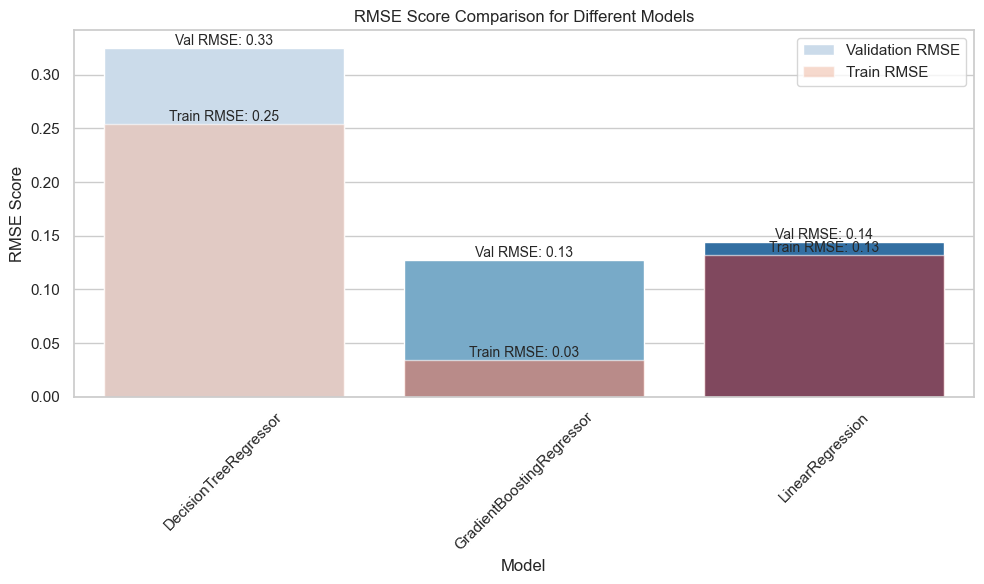

In [73]:
# Unpacking the data of the training into lists
model_names = []
rmse_train_scores = []
rmse_val_scores = []
y_preds = []

for model_name, (best_model, y_val_pred, rmse_val, y_train_pred, rmse_train) in best_models.items():
    model_names.append(model_name)
    rmse_val_scores.append(rmse_val)
    rmse_train_scores.append(rmse_train)
    y_preds.append(y_val_pred)

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")  # Set the style

# Create the bar plot with both train and validation RMSE
ax = sns.barplot(x=model_names, y=rmse_val_scores, palette="Blues", label="Validation RMSE")
ax = sns.barplot(x=model_names, y=rmse_train_scores, palette="Reds", label="Train RMSE", alpha=0.6)

plt.xlabel('Model')
plt.ylabel('RMSE Score')
plt.title('RMSE Score Comparison for Different Models')
plt.xticks(rotation=45)
plt.tight_layout()

# Add RMSE values as labels in each column
for i, (val_rmse, train_rmse) in enumerate(zip(rmse_val_scores, rmse_train_scores)):
    ax.text(i, val_rmse, f'Val RMSE: {val_rmse:.2f}', ha='center', va='bottom', fontsize=10)
    ax.text(i, train_rmse, f'Train RMSE: {train_rmse:.2f}', ha='center', va='bottom', fontsize=10)

ax.legend()
plt.show()

In the bar plots, we can see that the model that performs best on the validation set is the GradientBoostingRegressor, while the worst-performing model is the DecisionTree.

Looking at the training set metrics, the DecisionTreeRegressor appears as the best-performing model. However, its performance significantly deteriorates on the validation data, which might indicate overfitting and poor generalization.

On the other hand, the LinearRegression model exhibits the least overfitting and is very close in performance to the GradientBoostingRegressor.

Nevertheless, I have chosen to continue with the GradientBoosting model since it offers higher predictive capability and more hyperparameters to fine-tune, providing opportunities for further performance improvement.

## Evaluating the model on test data

In [74]:
X_train_final = train_df.drop(columns = target_variable)
y_train_final = train_df[target_variable]
X_test = test_df.drop(columns = target_variable)
y_test = test_df[target_variable]

In [75]:
print(study.best_trial.params)

{'classifier': 'GradientBoostingRegressor', 'n_estimators': 327, 'learning_rate': 0.03989576749220836}


In [76]:
#-------------------------------------------------------------------------
if study.best_trial.params['classifier'] == 'DecisionTreeRegressor':
    best_model = DecisionTreeRegressor(max_depth=study.best_params.get('max_depth'), min_samples_split=study.best_params.get('min_samples_split'))
elif study.best_trial.params['classifier']=='GradientBoostingRegressor':
    best_model = GradientBoostingRegressor(n_estimators=study.best_params.get('n_estimators'), learning_rate=study.best_params.get('learning_rate'))
else:
    best_model = LinearRegression()
#best_model = study.best_trial.params['classifier'](**study.best_params)
best_model.fit(X = X_train_final, y = y_train_final)
y_train_final_pred = best_model.predict(X = X_train_final)
y_test_pred = best_model.predict(X = X_test)

c:\Users\cbureu\.virtualenvs\TP_-_house_price-HatBpbIa\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



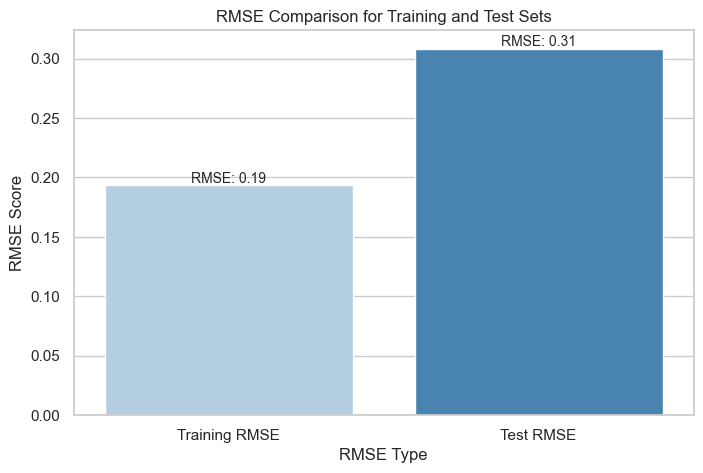

In [77]:
# Calculate RMSE for the training set
rmse_train = mean_squared_error(y_train_final, y_train_final_pred, squared=False)

# Calculate RMSE for the test set
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

# Create a bar plot
model_names = ['Training RMSE', 'Test RMSE']
rmse_scores = [rmse_train, rmse_test]

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")

# Create the bar plot
ax = sns.barplot(x=model_names, y=rmse_scores, palette="Blues")

plt.xlabel('RMSE Type')
plt.ylabel('RMSE Score')
plt.title('RMSE Comparison for Training and Test Sets')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal

# Add RMSE values as labels in each column
for i, v in enumerate(rmse_scores):
    ax.text(i, v, f'RMSE: {v:.2f}', ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show()

In the metrics for the test set, we can see that, as expected, the model's performance has declined. Nevertheless, the difference between the training and test sets is significant, suggesting the possibility of overfitting in the model, hindering its ability to generalize effectively. To address this issue, it would be advisable to reduce the model's complexity by modifying the hyperparameters.